In [1]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
import importlib
from tight_binding_redweasel import *
from tight_binding_redweasel.linalg import *
from tight_binding_redweasel import qespresso_interface as qe
from tight_binding_redweasel import fermi_surface as fs

### Coefficientfunctions
Define a couple functions for the coefficients for the tests.

In [2]:
def f_i_linear(k, i):
    assert i >= 0
    if i == 0:
        return np.ones_like(k[..., 0])
    return k[..., i-1]

def df_i_linear(k, i):
    assert i >= 0
    d = np.zeros_like(k)
    if i == 0:
        return d
    d[..., i-1] = 1.0
    return d

def ddf_i_linear(k, i):
    return np.zeros(np.shape(k) + (np.shape(k)[-1],))

def f_i_exp(k, i):
    assert i >= 0
    if i == 0:
        return np.ones_like(k[..., 0])
    if i % 2 == 1:
        return np.cos(k[..., (i-1)//2])
    else:
        return np.sin(k[..., (i-1)//2])

def df_i_exp(k, i):
    assert i >= 0
    d = np.zeros_like(k)
    if i == 0:
        return d
    d[..., (i-1)//2] = 1.0
    if i % 2 == 1:
        return -np.sin(k[..., (i-1)//2])[:,None] * d
    else:
        return np.cos(k[..., (i-1)//2])[:,None] * d

def ddf_i_exp(k, i):
    assert i >= 0
    d = np.zeros(np.shape(k) + (np.shape(k)[-1],))
    if i == 0:
        return d
    d[..., (i-1)//2, (i-1)//2] = 1.0
    if i % 2 == 1:
        return -np.cos(k[..., (i-1)//2])[:,None,None] * d
    else:
        return -np.sin(k[..., (i-1)//2])[:,None,None] * d

# Tests

[[[-2.018+0.j     0.   +0.j   ]
  [ 0.   -0.j     0.006-0.j   ]]

 [[-0.329+0.j     1.676+0.j   ]
  [ 1.676-0.j     0.482-0.j   ]]

 [[-0.071-0.j     1.528+0.953j]
  [ 1.528-0.953j -0.035-0.j   ]]]

preparing pseudoinverse

maximal acceleration 1.0
1000: loss 2.52e-05 3.2e-05×[██]final loss: 2.5161538051819714e-05
[[[-2.018-0.j    -0.   -0.j   ]
  [ 0.   -0.j     0.006+0.j   ]]

 [[-0.329+0.j     1.676-0.j   ]
  [ 1.676+0.j     0.482+0.j   ]]

 [[-0.071+0.j     1.528+0.953j]
  [ 1.528-0.953j -0.035+0.j   ]]]


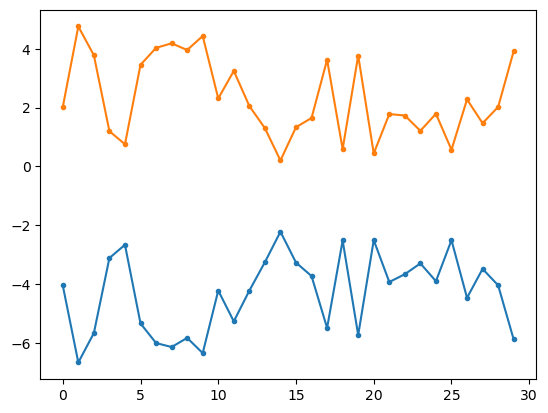

In [3]:
tb2 = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(2),
                         random_hermitian(2),
                         random_hermitian(2)])

tb2_ref = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(2),
                         random_hermitian(2),
                         random_hermitian(2)])
tb2_ref.normalize()
print(tb2_ref.params)

#k_smpl = np.linspace(-2, 2, 20).reshape(-1, 1)
k_smpl = np.random.random((30, 2))

ref_bands = tb2_ref.bands(k_smpl)
tb2.optimize(k_smpl, 1, ref_bands, [1, 1], 0, 1000)
print("final loss:", tb2.loss(k_smpl, ref_bands, [1, 1], 0))
print(tb2.params)

tb2_ref.plot_bands(k_smpl, '.')
tb2.plot_bands(k_smpl, '-')

In [4]:
# test gradients
tb2 = BandStructureModel(f_i_exp, df_i_exp,
                        [random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6),
                         random_hermitian(6)], ddf_i_exp)
tb2.normalize()

h = 1e-6
k_smpl = np.random.random((30, 3))
dx = np.reshape((h, 0, 0), (1, -1))
dy = np.reshape((0, h, 0), (1, -1))
dz = np.reshape((0, 0, h), (1, -1))

# test gradients
bands, grads = tb2.bands_grad(k_smpl)
bandsx = tb2.bands(k_smpl + dx)
bandsy = tb2.bands(k_smpl + dy)
bandsz = tb2.bands(k_smpl + dz)
# the following should be of order 10
print(np.linalg.norm(bands + (grads * dx.reshape(1,-1,1)).sum(1) - bandsx) / h**2)
print(np.linalg.norm(bands + (grads * dy.reshape(1,-1,1)).sum(1) - bandsy) / h**2)
print(np.linalg.norm(bands + (grads * dz.reshape(1,-1,1)).sum(1) - bandsz) / h**2)

# test hessians
k_smpl = np.random.random((30, 3))
bands, grads, hess = tb2.bands_grad_hess(k_smpl)
#print(np.linalg.norm(hess, axis=(0, -1)))
bandsx, gradsx = tb2.bands_grad(k_smpl + dx)
bandsy, gradsy = tb2.bands_grad(k_smpl + dy)
bandsz, gradsz = tb2.bands_grad(k_smpl + dz)
# the following should be of order 10
print(np.linalg.norm(grads + hess[:,:,0]*h - gradsx, axis=(0,2)) / h**2)
print(np.linalg.norm(grads + hess[:,:,1]*h - gradsy, axis=(0,2)) / h**2)
print(np.linalg.norm(grads + hess[:,:,2]*h - gradsz, axis=(0,2)) / h**2)


29.027524050419142
33.803929996681724
63.11580284026449
[103.455  49.764  74.488]
[ 34.788 144.842  62.288]
[108.571  69.825 282.318]


[[[-1.619+0.j     0.   -0.j    -0.   -0.j   ]
  [-0.   +0.j    -0.171-0.j    -0.   -0.j   ]
  [-0.   +0.j     0.   +0.j     1.05 -0.j   ]]

 [[ 0.774-0.j     0.701-0.j     0.691+0.903j]
  [ 0.701+0.j     0.852-0.j     0.529+0.j   ]
  [ 0.691-0.903j  0.529+0.j    -1.501+0.j   ]]]

preparing pseudoinverse

maximal acceleration 1.0
494: loss 4.52e-15 9.4e-15×[▂█▇]
converged
495: loss 4.62e-15 8.9e-15×[▃█▇]final loss: 4.6215962606571605e-15
[[[-1.619-0.j     0.   +0.j    -0.   -0.j   ]
  [ 0.   -0.j    -0.171+0.j     0.   -0.j   ]
  [-0.   +0.j     0.   +0.j     1.05 -0.j   ]]

 [[ 0.774+0.j     0.852-0.j    -0.047+0.927j]
  [ 0.852+0.j     0.852+0.j     0.691+0.j   ]
  [-0.047-0.927j  0.691-0.j    -1.501-0.j   ]]]


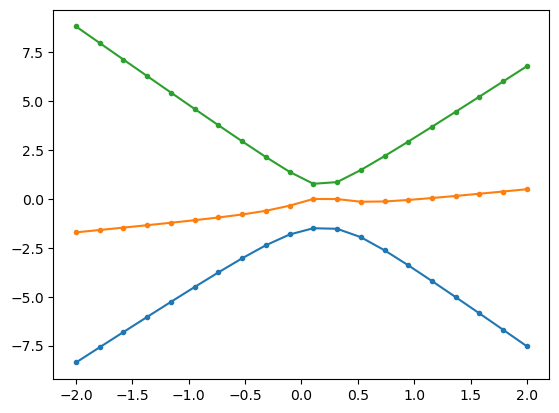

In [5]:
tb2 = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(3),
                         random_hermitian(3)])

tb2_ref = BandStructureModel(f_i_linear, df_i_linear,
                        [random_hermitian(3),
                         random_hermitian(3)])
tb2_ref.normalize()
print(tb2_ref.params)

k_smpl = np.linspace(-2, 2, 20).reshape(-1, 1)

ref_bands = tb2_ref.bands(k_smpl)
tb2.optimize(k_smpl, 1, ref_bands, [1, 1, 1], 0, 1000)
print("final loss:", tb2.loss(k_smpl, ref_bands, [1, 1, 1], 0))
print(tb2.params)

tb2_ref.plot_bands(k_smpl, '.')
tb2.plot_bands(k_smpl, '-')

# Real Data

For real data, use a tight binding model with just $\cos$ terms. The Hamilton operator of this model has only s symmetry orbitals. These orbitals can be located at any high symmtry point. Together they can form the orbitals that have a different symmetry.


preparing pseudoinverse

maximal acceleration 2.0
100: loss 4.89e-01 1.3e+00×[▁▁▁▂▂▂▂▁▃▂▂█▆▅▅▆]
preparing pseudoinverse

maximal acceleration 8.0
  0: loss 4.89e-01 1.3e+00×[▁▁▁▂▂▂▂▁▃▂▂█▆▅▅▆]
converged
  1: loss 4.89e-01 1.3e+00×[▁▁▁▂▂▂▂▁▃▂▂█▆▅▅▆]

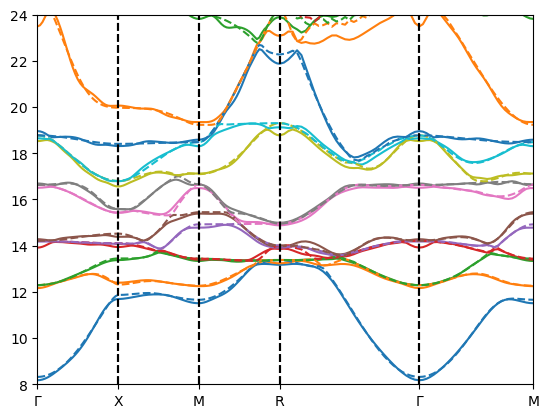

In [2]:
material = qe.from_disk("nitinol_2_993")
k_smpl, ref_bands, symmetries, fermi_energy = material.read_bands_crystal()
all_ref_bands = ref_bands
ref_bands = ref_bands[:,8:]
sym = Symmetry(symmetries)
ref_weights = sym.k_weight(k_smpl)

# now start my algorithm to find good matrices
add_bands = 0
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.5
weights[6] = 1
weights[7] = 1
weights[-1] = 0.5

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 1, 0), (2, 1, 1), (2, 2, 1), (3, 0, 0), (3, 1, 0), (2, 2, 2)) # works well
tb_nitinol = BandStructureModel.init_tight_binding_from_ref(sym, neighbors, k_smpl, ref_bands, band_offset, add_bands, cos_reduced=True)
#tb_nitinol = BandStructureModel.load("ni.repr") # careful this overrides the configuration
tb_nitinol.optimize(k_smpl, ref_weights, ref_bands, weights, band_offset, 100, 1, train_k0=True, learning_rate=0.5, max_accel_global=2.0, regularization=0.999)
tb_nitinol.optimize(k_smpl, ref_weights, ref_bands, weights, band_offset, 1000, 1, train_k0=True, learning_rate=0.5, max_accel_global=8.0, regularization=1.0)

path = kpaths.KPath('G').to('X').to('M').to('R').to('G').to('M')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.cubic(True), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

In [28]:
# save the model to a file for usage in further processing
tb_nitinol.save("ni.repr")

In [8]:
bands_map = { tuple(np.round(k, 4)): np.round(bands, 4)  for k, bands in zip(k_smpl, all_ref_bands)}
print(bands_map.keys())
bands = bands_map[(-0.5,-0.5,-0.5)]
#bands = bands_map[(0,0,0)]
print(bands)
# count degeneracies
unique = set(bands)
print("unique values:", len(unique))
print("1-sym:", len([b for b in unique if len([1 for b2 in bands if b2 == b]) == 1]))
print("2-sym:", len([b for b in unique if len([1 for b2 in bands if b2 == b]) == 2]))
print("3-sym:", len([b for b in unique if len([1 for b2 in bands if b2 == b]) == 3]))

dict_keys([(0.0, 0.0, 0.0), (0.0, 0.0, 0.0417), (0.0, 0.0, 0.0833), (0.0, 0.0, 0.125), (0.0, 0.0, 0.1667), (0.0, 0.0, 0.2083), (0.0, 0.0, 0.25), (0.0, 0.0, 0.2917), (0.0, 0.0, 0.3333), (0.0, 0.0, 0.375), (0.0, 0.0, 0.4167), (0.0, 0.0, 0.4583), (0.0, 0.0, -0.5), (0.0, 0.0417, 0.0417), (0.0, 0.0417, 0.0833), (0.0, 0.0417, 0.125), (0.0, 0.0417, 0.1667), (0.0, 0.0417, 0.2083), (0.0, 0.0417, 0.25), (0.0, 0.0417, 0.2917), (0.0, 0.0417, 0.3333), (0.0, 0.0417, 0.375), (0.0, 0.0417, 0.4167), (0.0, 0.0417, 0.4583), (0.0, 0.0417, -0.5), (0.0, 0.0833, 0.0833), (0.0, 0.0833, 0.125), (0.0, 0.0833, 0.1667), (0.0, 0.0833, 0.2083), (0.0, 0.0833, 0.25), (0.0, 0.0833, 0.2917), (0.0, 0.0833, 0.3333), (0.0, 0.0833, 0.375), (0.0, 0.0833, 0.4167), (0.0, 0.0833, 0.4583), (0.0, 0.0833, -0.5), (0.0, 0.125, 0.125), (0.0, 0.125, 0.1667), (0.0, 0.125, 0.2083), (0.0, 0.125, 0.25), (0.0, 0.125, 0.2917), (0.0, 0.125, 0.3333), (0.0, 0.125, 0.375), (0.0, 0.125, 0.4167), (0.0, 0.125, 0.4583), (0.0, 0.125, -0.5), (0.0, 0

In [9]:
for i, (r, mat) in enumerate(zip(neighbors + neighbors[1:], tb_nitinol.params)):
    print(r, np.linalg.norm(mat), "real" if np.linalg.norm(np.imag(mat)) < 1e-8 else "complex")

(0, 0, 0) 79.62186547079183 real
(1, 0, 0) 0.14494381248865312 complex
(1, 1, 0) 0.14751342070055104 complex
(1, 1, 1) 0.09727626930348156 complex
(2, 0, 0) 0.08068471428563735 complex
(2, 1, 0) 0.10283245095714115 complex
(2, 1, 1) 0.12417567039521717 complex
(2, 2, 1) 0.07967652877752983 complex
(3, 0, 0) 0.050094577023515 complex
(3, 1, 0) 0.08519444131294217 complex
(2, 2, 2) 0.04857918642681847 complex


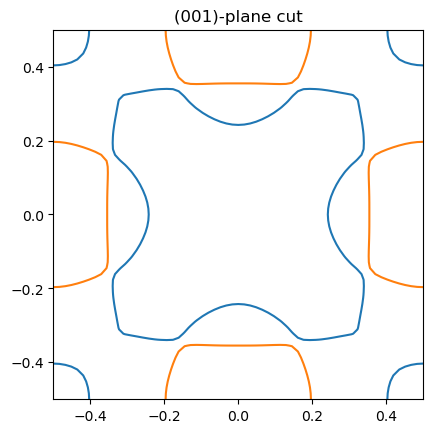

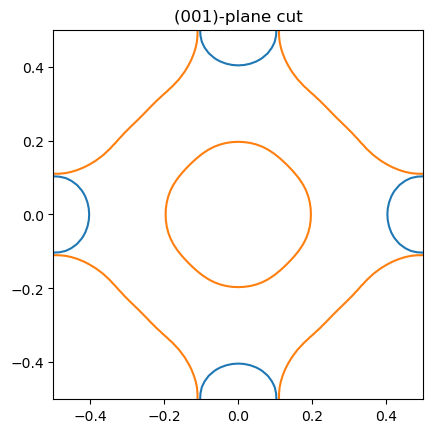

In [3]:
fermi_energy = 16.157
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63)

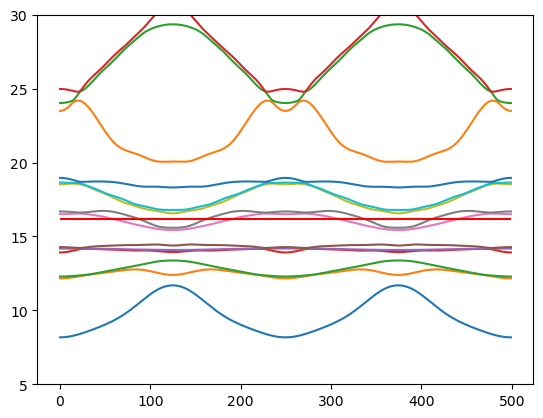

In [4]:
fermi_energy = 16.157
k_line = np.linspace(0, 2, 500).reshape(-1, 1) * [[1, 0, 0]]
tb_nitinol.plot_bands(k_line)
plt.hlines(fermi_energy, 0, len(k_line)-1, 'r')
plt.ylim(5, 30)
plt.show()

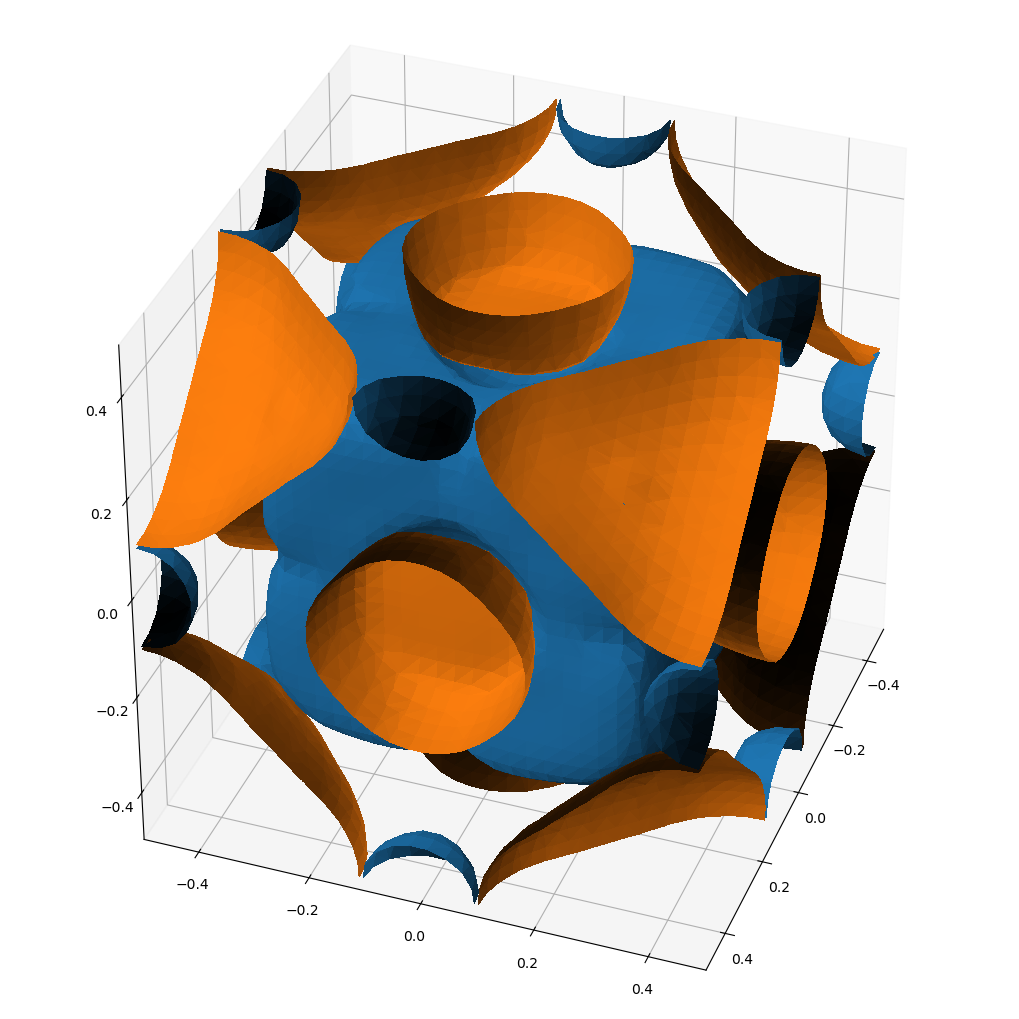

In [5]:
# plot the fermi surface
fermi_energy = 16.157
fs.plot_3D_fermi_surface(tb_nitinol, fermi_energy, N=32)